# HIV Comorbidity in TBSim 

This notebook demonstrates how to use the **HIV comorbidity module** in the `tbsim` package.

**Module Location:** `tbsim/comorbidities/hiv/`

---

## Overview

The HIV comorbidity module in TBSim allows users to simulate the impact of **HIV infection on TB disease dynamics**. Rather than modeling HIV progression in detail, it serves as a **lightweight comorbidity** that modifies TB risks based on HIV state.

The module is composed of three key components:

- **HIV Model**: Represents HIV infection as a comorbidity.
- **HIV Intervention**: Enables scenario testing via prevalence and ART coverage.
- **TB-HIV Connector**: Bridges HIV and TB models, applying comorbidity risk logic.

---

## HIV Model

The **HIV model** simulates HIV infection status and its progression through simplified states:

- `ACUTE`
- `LATENT`
- `AIDS`

This implementation is intended as a modifier for TB outcomes, rather than a standalone disease model.

### Key Parameters

| Parameter              | Description                                                                 |
|------------------------|-----------------------------------------------------------------------------|
| `init_prev`            | Probability of being HIV-positive (ACUTE stage) at simulation start         |
| `init_onart`           | Probability of being on ART if HIV-positive                                 |
| `acute_to_latent`      | Daily probability of transitioning from ACUTE to LATENT                     |
| `LATENT_to_aids`       | Daily probability of transitioning from LATENT to AIDS                      |
| `aids_to_dead`         | Daily probability of death after reaching AIDS (currently unused)           |
| `art_progression_factor` | Multiplier reducing HIV progression for agents on ART                      |


### *** Important: ***
>    At step 0, the model looks for the existance of an `HivIntervention` handling the HIV infection and art coverage, if none is found then it uses the values defined at Disease level to set the initial values.

---

## HIV Intervention

The `HivIntervention` class allows control over **HIV prevalence and ART coverage** in the population. This is useful for scenario testing and simulating public health campaigns.

### Supported Modes

- `'infection'`: Adjust HIV infection prevalence
- `'art'`: Adjust ART coverage
- `'both'`: Adjust both infection and treatment

### What It Does

- Applies changes to the **HIV state** of the population
- Operates within a specified time range (`start` to `stop`)
- Can be targeted to specific age groups or entire population

```python
intervention = HivInterventions(pars=dict(
    mode='both',
    prevalence=0.2,
    percent_on_ART=0.5,
    minimum_age=15,
    max_age=49,
    start=ss.date('2000-01-01'),
    stop=ss.date('2010-12-31'),
))
```

Also, the parameters shown above are the same ones that you can modify in order to run a different scenario. 

---

## TB-HIV Connector

The `TB_HIV_Connector` class links the TB and HIV models, simulating the **comorbidity effect** of HIV on TB progression.

### Purpose

Modifies TB progression parameters based on an individual's **current HIV state**.

### Risk Multiplier Table

| HIV State | TB Progression Risk Multiplier |
|-----------|-------------------------------|
| `ACUTE`   | 1.5                           |
| `LATENT`  | 2.0                           |
| `AIDS`    | 3.0                           |

### Behavior at Each Time Step

1. Identify all **TB-infected** individuals.
2. Look up their current **HIV state**.
3. Apply a **multiplier** to their TB `rr_activation` value (risk of progressing to active TB).

---

## Process Flow Diagram

```text
+-----------------+
|   TB Infection  |
+-----------------+
        |
        v
+-----------------+     +-----------------------+
|  HIV Comorbidity| --> | HIV State (ACUTE,...) |
+-----------------+     +-----------------------+
        |                          |
        |      TB_HIV_Connector    |
        +-------------------------> Applies RR Multiplier
                                   |
                                   v
                    +-------------------------------+
                    | TB rr_activation Adjusted     |
                    | Based on HIV State            |
                    +-------------------------------+
```

---

## Example Code


# Example

In [64]:
import tbsim
import starsim as ss
import sciris as sc
import numpy as np
import matplotlib.pyplot as plt# Rendering with Quatro


## Intervention
Adding a function to simplify the generation of an intervention.

This intervention will try to simulate a steady prevalence and on ART values along the entire simulation

In [65]:
def make_hiv_intervention(pars=None):
    if pars is None:
        pars=dict(
                mode='both',
                prevalence=0.30,            # Maintain 30 percent of the alive population infected
                percent_on_ART=0.50,        # Maintain 50 percent of the % infected population on ART
                min_age=15, max_age=60,     # Min and Max age of agents that can be hit with the intervention
                start=ss.date('2000-01-01'), stop=ss.date('2035-12-31'),   # Intervention's start and stop dates
        )
    intervention = tbsim.HivInterventions(pars=pars)
    return intervention

## Creating the simulation

In [66]:

def build_tbhiv_sim(simpars=None, tbpars=None, hivinv_pars=None) -> ss.Sim:
    sim_pars = dict(
        dt=ss.days(7),
        start=ss.date('1980-01-01'),
        stop=ss.date('2035-12-31'),
        rand_seed=123,
        verbose=0,
    )
    tb_pars = dict(
        init_prev=ss.bernoulli(p=0.25),
        rel_sus_latentslow=0.1,
    )

    hivinv_pars = hivinv_pars or dict(
        mode='both',
        prevalence=0.20,
        percent_on_ART=0.20,
        min_age=15, max_age=49,
        start=ss.date('2000-01-01'),
        stop=ss.date('2010-12-31'),
    )
    hiv_intervention = make_hiv_intervention(hivinv_pars)
    hiv = tbsim.HIV()
    connector = tbsim.TB_HIV_Connector()
    
    tb = tbsim.TB(pars=tb_pars)
    people = ss.People(n_agents=1_000)
    network = ss.RandomNet(pars=dict(n_contacts=ss.poisson(lam=2), dur=0))

    # --- Assemble Simulation ---
    sim = ss.Sim(
        people=people,
        diseases=[tb, hiv],
        interventions=[hiv_intervention], 
        networks=network,
        connectors=[connector],
        pars=sim_pars,
    )
    return sim


## Running the simulation

In [67]:

# Run the simulation: 
sim = build_tbhiv_sim()
sim.run()


HIV intervention present, skipping initialization.


Sim(n=1000; 1980.01.01—2035.12.31; connectors=tb_hiv_connector; networks=randomnet; interventions=hivinterventions; diseases=tb, hiv)

## Plot the results

Figure(1200x900)


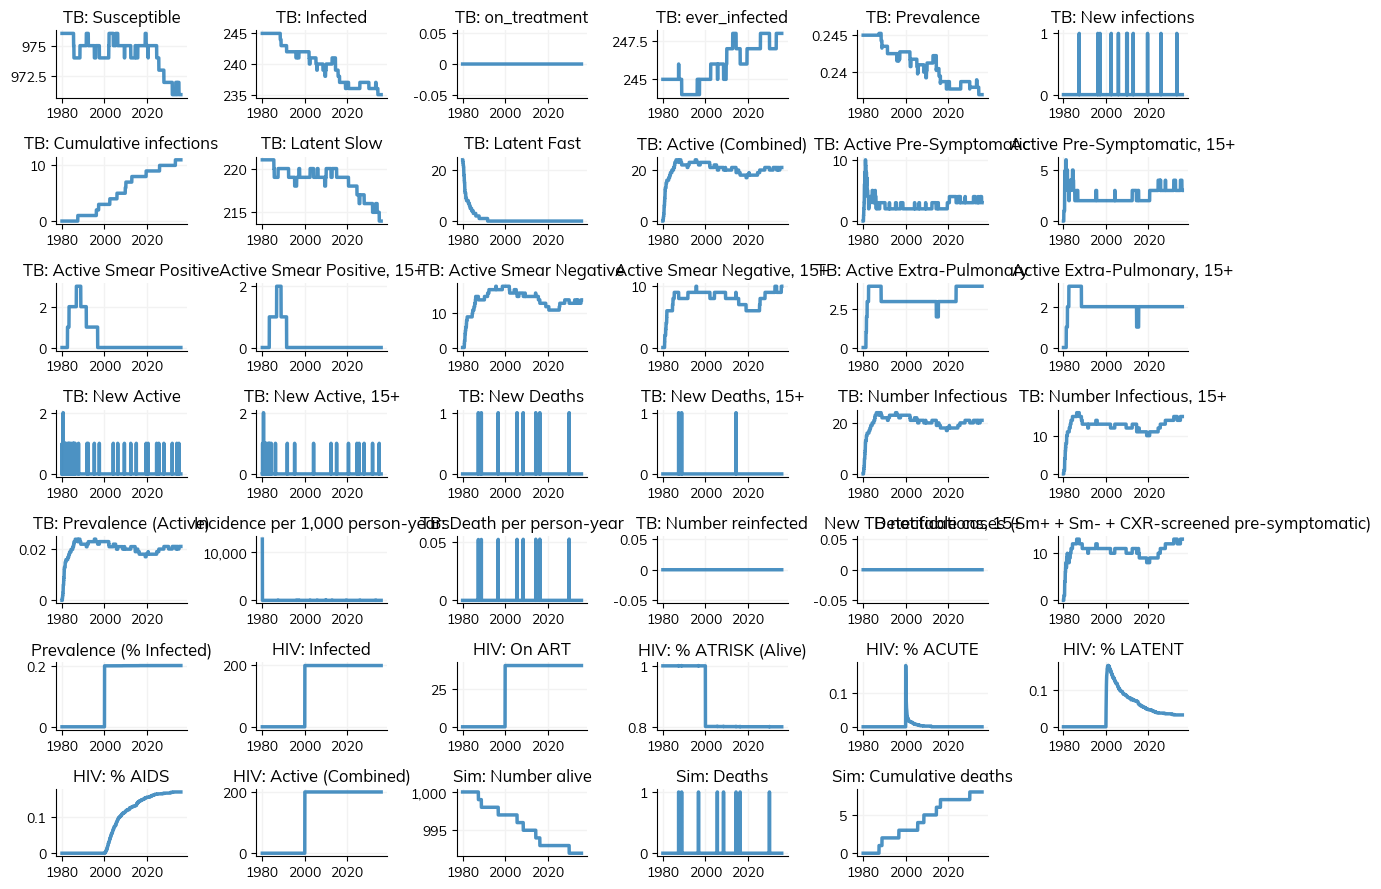

In [68]:

sim.plot()
plt.show()